In [2]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from scipy.sparse import issparse, coo_matrix, csr_matrix, csc_matrix
from scipy.sparse.linalg import eigsh
from openfermionpyscf import run_pyscf
from openfermion import MolecularData, get_fermion_operator
from openfermion.linalg import get_sparse_operator,  get_number_preserving_sparse_operator


In [3]:
def indices_with_N_and_Sz0(n_orbital, n_elec):
    """전자수=N 이면서 S_z=0 (interleaved: 짝수=alpha, 홀수=beta)"""
    idx = []
    for s in range(1 << n_orbital):
        if s.bit_count() != n_elec:
            continue
        n_alpha = sum((s >> i) & 1 for i in range(0, n_orbital, 2))  # 0,2,4,...
        n_beta  = sum((s >> i) & 1 for i in range(1, n_orbital, 2))  # 1,3,5,...
        if n_alpha == n_beta:
            idx.append(s)
    return np.array(idx, dtype=int)

def sparse_to_graph(A, *,
                    directed=False,
                    weight="value",   # "value" | "abs" | "binary"
                    symmetrize=True,  # 무향 그래프용: 패턴을 A + A.T로 합칠지
                    tol=0.0,          # |a_ij|<=tol 은 0 취급
                    keep_diagonal=False):
    """
    희소행렬 A -> NetworkX Graph/DiGraph 변환

    Parameters
    ----------
    A : scipy.sparse matrix (정방 추천)
    directed : bool
        True면 DiGraph, False면 Graph
    weight : {"value","abs","binary"}
        엣지 weight 설정 방법
        - "value": a_ij (실수/복소 가능; 복소는 실수부 사용 권장)
        - "abs"  : |a_ij|
        - "binary": 1 (연결만 표현)
    symmetrize : bool
        무향 그래프에서 A의 패턴을 A + A^T로 결합 (권장)
        directed=True 인 경우엔 무시됨
    tol : float
        임계값 이하 절댓값은 0으로 무시
    keep_diagonal : bool
        True면 i==j 항도 self-loop로 추가

    Returns
    -------
    G : nx.Graph or nx.DiGraph
    """
    if not issparse(A):
        raise ValueError("A must be a scipy.sparse matrix")
    # COO로 변환
    A = A.tocoo(copy=True)

    # tol 필터링
    if tol > 0:
        mask = np.abs(A.data) > tol
        A = coo_matrix((A.data[mask], (A.row[mask], A.col[mask])), shape=A.shape)

    # 대각 요소 처리
    if not keep_diagonal:
        mask = A.row != A.col
        A = coo_matrix((A.data[mask], (A.row[mask], A.col[mask])), shape=A.shape)

    # 무향이면 패턴 대칭화(권장): A <- A + A.T (중복은 합쳐짐)
    if not directed and symmetrize:
        AT = coo_matrix((A.data, (A.col, A.row)), shape=A.shape)
        A = (A + AT).tocoo()

    # 그래프 타입 선택
    G = nx.DiGraph() if directed else nx.Graph()
    G.add_nodes_from(range(A.shape[0]))  # 노드: 0..n-1

    # weight 설정
    if weight == "binary":
        # 동일 (i,j) 중복 합치기 위해 집계
        from collections import defaultdict
        edges = defaultdict(float)
        for i, j, v in zip(A.row, A.col, A.data):
            if not directed and i == j and not keep_diagonal:
                continue
            key = (i, j) if directed else (min(i, j), max(i, j))
            edges[key] = 1.0  # 존재만 표시
        for (i, j), w in edges.items():
            G.add_edge(i, j, weight=w)

    else:
        # "value" 또는 "abs"
        if weight == "abs":
            vals = np.abs(A.data)
        elif weight == "value":
            # 복소인 경우 실수부만 쓰고 싶다면 .real 사용
            # 필요에 따라 변경 가능: vals = np.real(A.data)
            vals = A.data
        else:
            raise ValueError("weight must be 'value', 'abs', or 'binary'")

        # 동일 엣지 중복 합치기(무향일 때 i<j 묶기)
        from collections import defaultdict
        edges = defaultdict(float)
        for i, j, v in zip(A.row, A.col, vals):
            if not directed and i == j and not keep_diagonal:
                continue
            key = (i, j) if directed else (min(i, j), max(i, j))
            edges[key] += float(v)  # 누적(합). 필요시 max/mean 등으로 변경 가능.

        for (i, j), w in edges.items():
            G.add_edge(i, j, weight=w)

    return G

In [4]:
def sparse_to_graph(A, *,
                    directed=False,
                    weight="value",   # "value" | "abs" | "binary"
                    symmetrize=True,  # 무향 그래프용: 패턴을 A + A.T로 합칠지
                    tol=0.0,          # |a_ij|<=tol 은 0 취급
                    keep_diagonal=False):
    """
    희소행렬 A -> NetworkX Graph/DiGraph 변환

    Parameters
    ----------
    A : scipy.sparse matrix (정방 추천)
    directed : bool
        True면 DiGraph, False면 Graph
    weight : {"value","abs","binary"}
        엣지 weight 설정 방법
        - "value": a_ij (실수/복소 가능; 복소는 실수부 사용 권장)
        - "abs"  : |a_ij|
        - "binary": 1 (연결만 표현)
    symmetrize : bool
        무향 그래프에서 A의 패턴을 A + A^T로 결합 (권장)
        directed=True 인 경우엔 무시됨
    tol : float
        임계값 이하 절댓값은 0으로 무시
    keep_diagonal : bool
        True면 i==j 항도 self-loop로 추가

    Returns
    -------
    G : nx.Graph or nx.DiGraph
    """
    if not issparse(A):
        raise ValueError("A must be a scipy.sparse matrix")
    # COO로 변환
    A = A.tocoo(copy=True)

    # tol 필터링
    if tol > 0:
        mask = np.abs(A.data) > tol
        A = coo_matrix((A.data[mask], (A.row[mask], A.col[mask])), shape=A.shape)

    # 대각 요소 처리
    if not keep_diagonal:
        mask = A.row != A.col
        A = coo_matrix((A.data[mask], (A.row[mask], A.col[mask])), shape=A.shape)

    # 무향이면 패턴 대칭화(권장): A <- A + A.T (중복은 합쳐짐)
    if not directed and symmetrize:
        AT = coo_matrix((A.data, (A.col, A.row)), shape=A.shape)
        A = (A + AT).tocoo()

    # 그래프 타입 선택
    G = nx.DiGraph() if directed else nx.Graph()
    G.add_nodes_from(range(A.shape[0]))  # 노드: 0..n-1

    # weight 설정
    if weight == "binary":
        # 동일 (i,j) 중복 합치기 위해 집계
        from collections import defaultdict
        edges = defaultdict(float)
        for i, j, v in zip(A.row, A.col, A.data):
            if not directed and i == j and not keep_diagonal:
                continue
            key = (i, j) if directed else (min(i, j), max(i, j))
            edges[key] = 1.0  # 존재만 표시
        for (i, j), w in edges.items():
            G.add_edge(i, j, weight=w)

    else:
        # "value" 또는 "abs"
        if weight == "abs":
            vals = np.abs(A.data)
        elif weight == "value":
            # 복소인 경우 실수부만 쓰고 싶다면 .real 사용
            # 필요에 따라 변경 가능: vals = np.real(A.data)
            vals = A.data
        else:
            raise ValueError("weight must be 'value', 'abs', or 'binary'")

        # 동일 엣지 중복 합치기(무향일 때 i<j 묶기)
        from collections import defaultdict
        edges = defaultdict(float)
        for i, j, v in zip(A.row, A.col, vals):
            if not directed and i == j and not keep_diagonal:
                continue
            key = (i, j) if directed else (min(i, j), max(i, j))
            edges[key] += float(v)  # 누적(합). 필요시 max/mean 등으로 변경 가능.

        for (i, j), w in edges.items():
            G.add_edge(i, j, weight=w)

    return G

### 행렬만들기

In [ ]:
dist = 1.322
geometry = [('H', (0., 0., 0.)),
            ('H', (0., 0., 0.7414 )),
            ('H', (0., 0., 0 + dist)),
            ('H', (0., 0., 0.7414 + dist))]  # Angstrom

# geometry = [("Co", Co),
#             ("O", O_1),
#             ("O", O_2),
#             ("Li", Li)]  # Angstrom

basis = 'sto-3g'
mol = MolecularData(geometry, basis, multiplicity=1, charge=0)

# 2. PySCF 실행 (SCF까지만 해도 충분)
mol = run_pyscf(mol, run_scf=1)

# 3. 2차 정량화 Hamiltonian 얻기
ham_int = mol.get_molecular_hamiltonian()
ham_fci = get_fermion_operator(ham_int)

print("Number of terms:", len(ham_fci.terms))
for term, coeff in list(ham_fci.terms.items())[:10]:
    print(term, coeff)
    
    
H = get_sparse_operator(ham_fci, n_qubits=mol.n_qubits)
# 2) N=2, S_z=0 서브스페이스 (H2/STO-3G면 4x4)
idx_N2_Sz0 = indices_with_N_and_Sz0(mol.n_qubits, n_elec=4)
print(idx_N2_Sz0)
H_cons = H[idx_N2_Sz0, :][:, idx_N2_Sz0].tocsr()
print(H_cons)

Number of terms: 529
() 3.395969155303167
((0, 1), (0, 0)) -2.341377471587156
((0, 1), (4, 0)) 0.21402565401395582
((1, 1), (1, 0)) -2.341377471587156
((1, 1), (5, 0)) 0.21402565401395582
((2, 1), (2, 0)) -1.793073669915166
((2, 1), (6, 0)) 0.1748537215681315
((3, 1), (3, 0)) -1.793073669915166
((3, 1), (7, 0)) 0.1748537215681315
((4, 1), (0, 0)) 0.21402565401395596
[ 15  27  30  39  45  51  54  57  60  75  78  90  99 102 105 108 114 120
 135 141 147 150 153 156 165 177 180 195 198 201 204 210 216 225 228 240]
<Compressed Sparse Row sparse matrix of dtype 'complex128'
	with 524 stored elements and shape (36, 36)>
  Coords	Values
  (0, 0)	(3.250947318196569+0j)
  (0, 2)	(0.10386287796753066+0j)
  (0, 4)	(-0.10386287796753073+0j)
  (0, 5)	(0.15769026196912034+0j)
  (0, 8)	(0.0945803378024111+0j)
  (0, 9)	(0.008345131608166743+0j)
  (0, 11)	(-0.06414921172182608+0j)
  (0, 13)	(-0.023172392700854506+0j)
  (0, 14)	(0.08732160442268058+0j)
  (0, 18)	(-0.008345131608166783+0j)
  (0, 21)	(0.08

### 행렬 히트맵 확인용

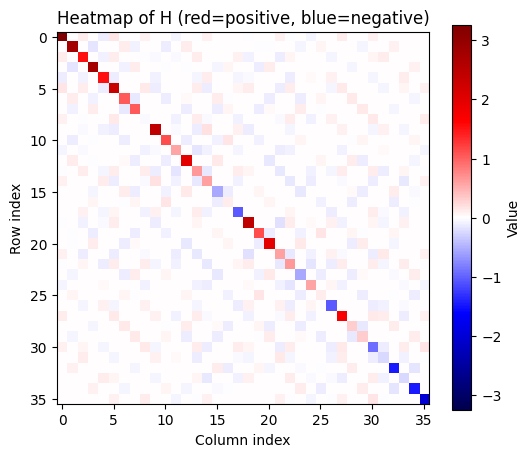

In [23]:
# H: 희소행렬 (예: CSR/COO/CSC)
# 여기서는 예시로 만듦
# H = csr_matrix([[ 1, -2, 0],
#                 [ 0,  3, -4],
#                 [-1,  0,  2]])

# 1) dense array 변환
H_real = H_N2_Sz0.real
H_dense = H_real.toarray()


# 2) 히트맵 그리기
plt.figure(figsize=(6,5))

# 값 크기에 맞게 대칭적인 색범위 설정
vmax = np.abs(H_dense).max()

im = plt.imshow(H_dense, cmap='seismic', vmin=-vmax, vmax=vmax)
plt.colorbar(im, label="Value")

plt.title("Heatmap of H (red=positive, blue=negative)")
plt.xlabel("Column index")
plt.ylabel("Row index")
plt.show()

### 그래프 표현(무향)

연결 성분: [{0, 2, 4, 5, 8, 9, 11, 13, 14, 17, 18, 21, 22, 24, 26, 27, 30, 31, 33, 35}, {32, 1, 34, 3, 6, 7, 10, 12, 15, 16, 19, 20, 23, 25, 28, 29}]


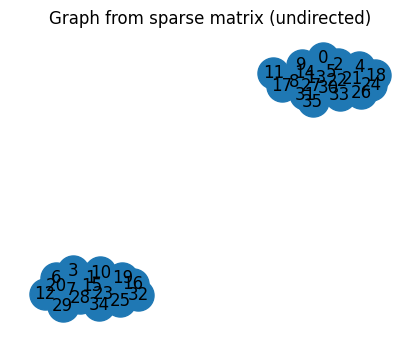

In [26]:
# 1) 무향 그래프 (구조적 연결성 확인용)
G = sparse_to_graph(H_real, directed=False, weight="abs", symmetrize=True, tol=0.0)

# 연결 성분
ccs = list(nx.connected_components(G))
print("연결 성분:", ccs)  # 예: [{0,1}, {2,3}]

sub_mat_idx = list(ccs[0])
# 각 성분의 서브그래프
subgraphs = [G.subgraph(S).copy() for S in ccs]

pos = nx.spring_layout(G, seed=0)
edge_w = [d["weight"] for *_, d in G.edges(data=True)]

plt.figure(figsize=(4,3))
nx.draw(G, pos, with_labels=True, node_size=500, width=edge_w)  # weight를 두께로
plt.title("Graph from sparse matrix (undirected)")
plt.show()

In [27]:
print(sub_mat_idx)

[0, 2, 4, 5, 8, 9, 11, 13, 14, 17, 18, 21, 22, 24, 26, 27, 30, 31, 33, 35]


In [29]:
# 희소행렬 H에서 부분행렬 뽑기
H_sub = H_cons[sub_mat_idx, :][:, sub_mat_idx]

eigval, eigvec = eigsh(H_sub, k=1, which='SA') 
print(eigval)

[-2.0264693]
